### This notebook contains code for generating batch-corrected versions of the RNAseq data in the 24q2 data release and uploading them to Taiga.

In [1]:
from taigapy import TaigaClient
import pandas as pd
from inmoose.pycombat import pycombat_norm, pycombat_seq
import numpy as np

In [2]:
tc = TaigaClient()

In [4]:
OmicsExpressionProteinCodingGenesTPMLogp1_internal = tc.get(name='internal-24q4-8c04', version=84, file='OmicsExpressionProteinCodingGenesTPMLogp1')
OmicsExpressionProteinCodingGenesTPMLogp1Stranded_internal = tc.get(name='internal-24q4-8c04', version=84, file='OmicsExpressionProteinCodingGenesTPMLogp1Stranded')

OmicsExpressionProteinCodingGenesTPMLogp1_public = tc.get(name='public-24q4-31a4', version=41, file='OmicsExpressionProteinCodingGenesTPMLogp1')
OmicsExpressionProteinCodingGenesTPMLogp1Stranded_public = tc.get(name='public-24q4-31a4', version=41, file='OmicsExpressionProteinCodingGenesTPMLogp1Stranded')

[##################]100% |   8.1 MiB/s | 136.7 MiB / 136.7 MiB | Time:  0:00:16
[##################]100% |  11.0 MiB/s |  54.2 MiB /  54.2 MiB | Time:  0:00:04


In [5]:
OmicsProfiles_internal = tc.get(name='internal-24q4-8c04', version=84, file='OmicsProfiles')
OmicsProfiles_public = tc.get(name='public-24q4-31a4', version=41, file='OmicsProfiles')

[##################]100% |  32.0 MiB/s |  94.1 KiB /  94.1 KiB | ETA:  00:00:00
[##################]100% |  40.9 MiB/s |  70.7 KiB /  70.7 KiB | ETA:  00:00:00


In [6]:
OmicsDefaultModelProfiles_internal = tc.get(name='internal-24q4-8c04', version=84, file='OmicsDefaultModelProfiles')
OmicsDefaultModelProfiles_public = tc.get(name='public-24q4-31a4', version=41, file='OmicsDefaultModelProfiles')

[##################]100% |  18.4 MiB/s |  38.2 KiB /  38.2 KiB | ETA:  00:00:00
[##################]100% |  20.4 MiB/s |  30.3 KiB /  30.3 KiB | ETA:  00:00:00


### Internal

Retreive profile IDs for internal and filter based on strandedness. Some profile IDs correspond to the same model ID, so remove duplicates using OmicsDefaultModelProfiles.

In [8]:
nonstranded_profiles = OmicsProfiles_internal[OmicsProfiles_internal['Stranded'] == False]['ProfileID']

In [9]:
nonstranded_model_ids = OmicsDefaultModelProfiles_internal[OmicsDefaultModelProfiles_internal['ProfileID'].isin(nonstranded_profiles)]['ModelID']

In [10]:
stranded_profiles = OmicsProfiles_internal[OmicsProfiles_internal['Stranded'] == True]['ProfileID']

In [11]:
stranded_model_ids = OmicsDefaultModelProfiles_internal[OmicsDefaultModelProfiles_internal['ProfileID'].isin(stranded_profiles)]['ModelID']

In [12]:
len(nonstranded_model_ids), len(stranded_model_ids)

(989, 1161)

Find overlapping gene names between the original expression dataset (includes unstranded RNAseq w/ unstranded RSEM mode + stranded RNAseq w/ unstranded RSEM mode) and new expression dataset (stranded RNAseq w/ stranded RSEM mode). 

In [13]:
genes_overlap_ids = list(set(OmicsExpressionProteinCodingGenesTPMLogp1Stranded_internal.loc[stranded_model_ids].columns).intersection(set(OmicsExpressionProteinCodingGenesTPMLogp1_internal.loc[nonstranded_model_ids].columns)))

In [14]:
nonstranded_24q4 = OmicsExpressionProteinCodingGenesTPMLogp1_internal.loc[nonstranded_model_ids, genes_overlap_ids]

In [15]:
stranded_24q4 = OmicsExpressionProteinCodingGenesTPMLogp1Stranded_internal.loc[stranded_model_ids, genes_overlap_ids]

In [17]:
tpm_24q4 = pd.concat((nonstranded_24q4, stranded_24q4), axis=0)

In [18]:
tpm_24q4

,TFE3 (7030),MMADHC (27249),PABPC1L (80336),RELL2 (285613),GPT (2875),GUSB (2990),H4-16 (121504),DDB2 (1643),RPS4X (6191),HINFP (25988),...,OR2A42 (402317),HOXB7 (3217),NSA2 (10412),UGT2B11 (10720),ZNF747 (65988),NAA60 (79903),MYH4 (4622),MTAP (4507),C14orf93 (60686),NR3C2 (4306)
ACH-000873,3.818646,3.925999,5.492494,2.648465,0.918386,5.340562,1.475085,4.682573,10.153045,3.155425,...,0.070389,3.915521,5.175125,0.00000,2.163499,4.366672,0.000000,3.948601,2.238787,0.201634
ACH-000860,4.375039,6.828200,5.379205,3.066950,0.432959,5.873075,1.339137,4.489928,10.286327,4.269781,...,0.056584,0.070389,6.694602,0.00000,1.536053,4.481557,0.000000,4.849999,3.395063,0.367371
ACH-000439,3.493135,5.904725,2.678072,4.596339,0.659925,6.773996,0.545968,4.587965,11.649301,4.901108,...,0.000000,0.042644,6.818007,1.62293,3.330558,4.757023,0.000000,4.165108,2.244887,0.014355
ACH-000318,3.911692,5.912171,5.100557,2.611172,0.757023,5.380937,2.587365,5.156639,9.284107,2.788686,...,0.000000,3.102658,5.592457,0.00000,2.500802,4.050502,0.000000,0.464668,3.247928,0.275007
ACH-001142,6.194560,6.989934,5.031660,2.875780,0.226509,4.826803,2.634593,4.300856,10.251956,3.975447,...,0.084064,3.629939,7.339494,0.00000,2.459432,5.008989,0.000000,4.420213,2.400538,0.516015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-003180,4.963474,7.860466,0.713696,1.056584,0.014355,6.195938,0.176323,4.538538,9.385582,2.726831,...,0.028569,4.688180,6.307793,0.00000,2.397803,4.982309,0.028569,4.721373,2.629939,0.014355
ACH-001979,4.776630,7.784177,2.014355,2.541019,0.014355,6.592607,0.516015,5.462380,11.351436,2.440952,...,0.000000,4.715893,7.349701,0.00000,2.077243,5.027243,0.000000,4.830357,2.724650,0.536053
ACH-003274,3.198494,6.947199,0.985500,3.226509,0.042644,5.476382,0.250962,2.925999,10.752715,3.531069,...,0.000000,0.000000,7.003265,0.00000,2.313246,4.918386,0.014355,4.075533,3.655352,0.084064
ACH-002748,3.902074,6.891662,0.201634,2.596935,1.459432,6.917312,0.823749,2.408712,9.060074,3.211012,...,0.000000,2.680324,5.912889,0.00000,1.655352,5.101818,0.000000,2.724650,1.978196,2.173127


In [19]:
strandness = np.array([0] * len(nonstranded_model_ids) + [1] * len(stranded_model_ids))

In [20]:
tpm_corrected_24q4 = pycombat_norm(tpm_24q4.T, strandness)

[INFO] Found 2 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.


[[0.85982486]
 [0.5804618 ]
 [1.33181384]
 ...
 [1.79618326]
 [0.62320507]
 [0.75578488]] [[False False False ... False False False]]
[[0.85982486 0.85982486 0.85982486 ... 0.85982486 0.85982486 0.85982486]
 [0.5804618  0.5804618  0.5804618  ... 0.5804618  0.5804618  0.5804618 ]
 [1.33181384 1.33181384 1.33181384 ... 1.33181384 1.33181384 1.33181384]
 ...
 [1.79618326 1.79618326 1.79618326 ... 1.79618326 1.79618326 1.79618326]
 [0.62320507 0.62320507 0.62320507 ... 0.62320507 0.62320507 0.62320507]
 [0.75578488 0.75578488 0.75578488 ... 0.75578488 0.75578488 0.75578488]]


[INFO] Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
[INFO] Adjusting the Data


In [21]:
tpm_corrected_24q4 = tpm_corrected_24q4.T

In [23]:
tpm_corrected_24q4

,TFE3 (7030),MMADHC (27249),PABPC1L (80336),RELL2 (285613),GPT (2875),GUSB (2990),H4-16 (121504),DDB2 (1643),RPS4X (6191),HINFP (25988),...,OR2A42 (402317),HOXB7 (3217),NSA2 (10412),UGT2B11 (10720),ZNF747 (65988),NAA60 (79903),MYH4 (4622),MTAP (4507),C14orf93 (60686),NR3C2 (4306)
ACH-000873,3.506205,3.584484,4.572699,2.137186,0.525915,5.041027,1.179124,4.345084,10.069657,2.869262,...,0.032995,3.748717,5.155622,-0.009160,1.952132,4.141739,-0.000116,3.782797,2.193078,0.245980
ACH-000860,4.089100,6.886964,4.430887,2.528341,0.117545,5.589460,1.053103,4.127051,10.209273,4.024218,...,0.023290,-0.160952,6.753527,-0.009160,1.357422,4.268943,-0.000116,4.690644,3.372848,0.417233
ACH-000439,3.165189,5.836121,1.049685,3.957850,0.308481,6.517316,0.317849,4.238008,11.637030,4.678546,...,-0.016486,-0.189162,6.883302,2.206492,3.058301,4.573945,-0.000116,4.000853,2.199302,0.052468
ACH-000318,3.603682,5.844594,4.082083,2.102328,0.390166,5.082609,2.210189,4.881627,9.159418,2.489161,...,-0.016486,2.922211,5.594495,-0.009160,2.271837,3.791668,-0.000116,0.273937,3.222723,0.321795
ACH-001142,5.995286,7.071005,3.995839,2.349655,-0.056134,4.511908,2.253969,3.913061,10.173268,3.719160,...,0.042608,3.458342,7.431706,-0.009160,2.232625,4.852927,-0.000116,4.257783,2.358115,0.570824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-003180,5.165957,7.735123,1.888620,1.447676,0.305600,6.416978,0.369623,4.781201,9.478081,2.966378,...,0.097491,4.816006,6.277112,0.002097,2.609723,5.097519,0.023647,4.856428,2.661060,-0.016156
ACH-001979,4.985783,7.665280,3.026326,3.032295,0.305600,6.804347,0.735648,5.629513,11.373898,2.688530,...,0.018964,4.843341,7.279101,0.002097,2.272606,5.139305,-0.000713,4.964760,2.754223,0.492046
ACH-003274,3.463985,6.899029,2.126371,3.764047,0.340686,5.714290,0.450048,3.300497,10.796507,3.748022,...,0.018964,0.191719,6.945938,0.002097,2.520798,5.038073,0.011527,4.214451,3.669716,0.051750
ACH-002748,4.142447,6.848186,1.440711,3.091984,2.097855,7.121441,1.067238,2.825501,9.164170,3.436956,...,0.018964,2.835515,5.897340,0.002097,1.828925,5.208657,-0.000713,2.871649,2.019966,2.086770


In [24]:
tpm_corrected_24q4.to_csv('/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv')

In [25]:
from taigapy import default_tc as tc

new_dataset_id = tc.update_dataset(
    changes_description="adding batch corrected version to 24Q4 release",
    dataset_permaname="internal-24q4-8c04",
    upload_files=[
        {
            "path": "/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv",
            "name": "OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected", # optional, will use file name if not provided
            "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    add_all_existing_files=True,
    upload_async=False,
    dataset_description="24Q4 release of the DepMap dataset for the DepMap Portal. Please look at the README file for additional information about this dataset.", # optional (but recommended)
)

No dataset version provided. Using version 84.
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to S3
Uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/4c00c1f794e147d3a2d00281e0147f77


Validate batch correction does what it is supposed to:

In [62]:
len(strandness)

2150

In [63]:
lineage_v2 = [0]*len(strandness)

In [61]:
print(tpm_corrected_24q4.shape)

(2150, 19139)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/4140144695.py:21: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(2150, 5) (2150,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/4140144695.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/4140144695.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/4140144695.py:27: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(2150, 10) (2150,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/4140144695.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/4140144695.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/4140144695.py:33: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(2150, 30) (2150,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/4140144695.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/4140144695.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)



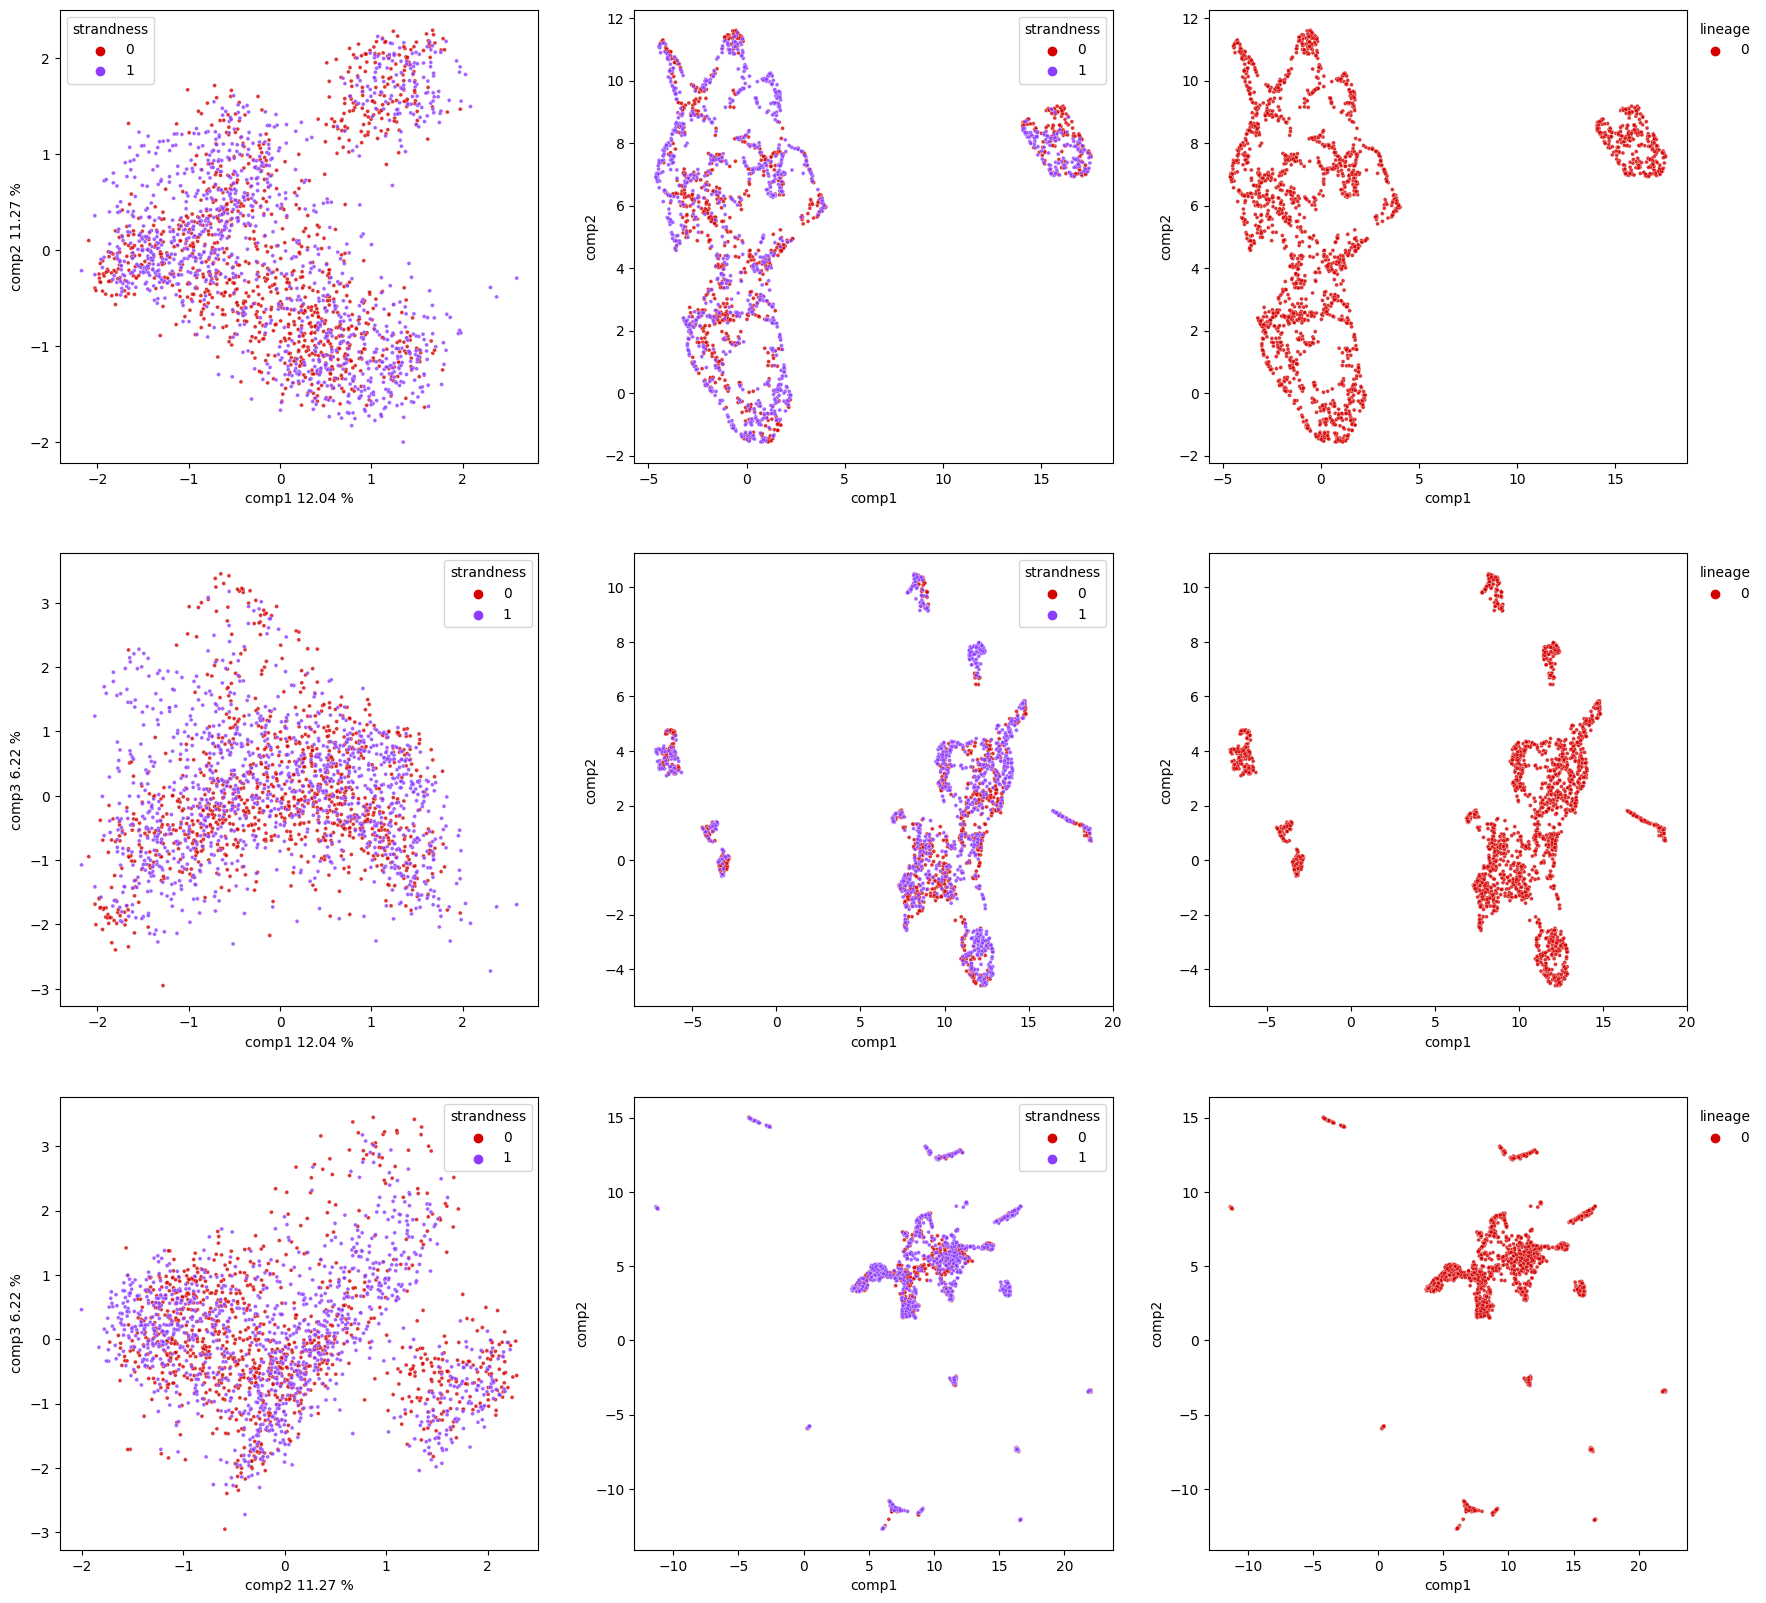

In [64]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
import seaborn as sns
import matplotlib.pyplot as plt
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(21, 20)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
#     strandness = np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*len(paired_data)])
    components = pca.fit_transform(tpm_corrected_24q4)
    print(components.shape, strandness.shape)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage_v2, "strandness": strandness})
        # pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*len(paired_data)])})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage_v2, "strandness": strandness})
        # pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage_v2, "strandness": strandness})
        # pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage_v2, "strandness": strandness})
    # pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage_v2, "strandness": strandness})
    # pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)


### Public

In [30]:
nonstranded_profiles = OmicsProfiles_public[OmicsProfiles_public['Stranded'] == False]['ProfileID']

In [31]:
nonstranded_model_ids_public = OmicsDefaultModelProfiles_public[OmicsDefaultModelProfiles_public['ProfileID'].isin(nonstranded_profiles)]['ModelID']

In [32]:
stranded_profiles = OmicsProfiles_public[OmicsProfiles_public['Stranded'] == True]['ProfileID']

In [33]:
stranded_model_ids_public = OmicsDefaultModelProfiles_public[OmicsDefaultModelProfiles_public['ProfileID'].isin(stranded_profiles)]['ModelID']

In [34]:
len(nonstranded_model_ids_public), len(stranded_model_ids_public)

(989, 684)

In [35]:
genes_overlap_ids_public = list(set(OmicsExpressionProteinCodingGenesTPMLogp1Stranded_public.loc[stranded_model_ids_public].columns).intersection(set(OmicsExpressionProteinCodingGenesTPMLogp1_public.loc[nonstranded_model_ids_public].columns)))

In [36]:
nonstranded_24q4_public = OmicsExpressionProteinCodingGenesTPMLogp1_public.loc[nonstranded_model_ids_public, genes_overlap_ids_public]

In [37]:
stranded_24q4_public = OmicsExpressionProteinCodingGenesTPMLogp1Stranded_public.loc[stranded_model_ids_public, genes_overlap_ids_public]

In [39]:
tpm_24q4_public = pd.concat((nonstranded_24q4_public, stranded_24q4_public), axis=0)

Drop the gene below from expression matrix since the variance is zero across model IDs, which leads to a divide-by-zero error when doing batch correction:

In [46]:
tpm_24q4_public = tpm_24q4_public.drop(columns=['DEFB131A (644414)'])

In [47]:
strandness_public = np.array([0] * len(nonstranded_model_ids_public) + [1] * len(stranded_model_ids_public))

In [48]:
len(strandness_public)

1673

In [49]:
from inmoose.pycombat import pycombat_norm

In [50]:
tpm_corrected_24q4_public = pycombat_norm(tpm_24q4_public.T, strandness_public)

[INFO] Found 2 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.


[[0.86370155]
 [0.58826186]
 [1.21144675]
 ...
 [1.79688349]
 [0.62132947]
 [0.73576026]] [[False False False ... False False False]]
[[0.86370155 0.86370155 0.86370155 ... 0.86370155 0.86370155 0.86370155]
 [0.58826186 0.58826186 0.58826186 ... 0.58826186 0.58826186 0.58826186]
 [1.21144675 1.21144675 1.21144675 ... 1.21144675 1.21144675 1.21144675]
 ...
 [1.79688349 1.79688349 1.79688349 ... 1.79688349 1.79688349 1.79688349]
 [0.62132947 0.62132947 0.62132947 ... 0.62132947 0.62132947 0.62132947]
 [0.73576026 0.73576026 0.73576026 ... 0.73576026 0.73576026 0.73576026]]


[INFO] Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
[INFO] Adjusting the Data


In [51]:
tpm_corrected_24q4_public

,ACH-000873,ACH-000860,ACH-000439,ACH-000318,ACH-001142,ACH-000789,ACH-000544,ACH-000531,ACH-000695,ACH-000399,...,ACH-002996,ACH-003061,ACH-001384,ACH-001700,ACH-002470,ACH-001843,ACH-002074,ACH-001164,ACH-003180,ACH-001979
TFE3 (7030),3.607691,4.192566,3.265517,3.705500,6.105227,3.610912,2.446179,5.681865,4.364434,4.619134,...,5.586557,4.076275,5.469260,4.482530,3.543934,5.343844,5.252185,4.050893,5.161680,4.986577
MMADHC (27249),3.531071,6.865682,5.804615,5.813170,7.051513,6.427401,5.885347,6.781293,6.502812,6.828655,...,7.616900,6.957816,6.276709,6.061848,6.524889,6.553367,6.258400,6.248805,7.678250,7.612689
PABPC1L (80336),4.982285,4.853288,1.777636,4.536005,4.457555,4.756976,2.603382,1.889260,3.187749,5.524087,...,2.992110,5.160160,4.805626,3.787419,3.395479,5.674036,2.872415,2.790849,1.932748,3.058782
RELL2 (285613),2.326016,2.725583,4.185835,2.290409,2.543055,4.364494,2.392491,2.070912,3.921761,2.794511,...,2.219140,3.081301,2.934213,2.397418,0.801529,3.390159,1.886574,1.599247,1.463134,3.065330
GPT (2875),0.607679,0.197016,0.389025,0.471169,0.022363,0.929382,0.112811,-0.009340,0.633240,1.020185,...,0.394206,0.814637,0.437848,0.663686,0.372059,0.644076,0.796319,0.663686,0.394206,0.394206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NAA60 (79903),4.213717,4.334535,4.624226,3.881219,4.889203,4.739785,3.552251,4.360793,5.393965,5.829421,...,3.665560,4.485363,4.352813,5.027732,4.295766,4.885868,5.964889,4.824132,5.139537,5.181626
MYH4 (4622),-0.001724,-0.001724,-0.001724,-0.001724,-0.001724,-0.001724,-0.001724,-0.001724,-0.001724,-0.001724,...,0.000741,0.066796,0.000741,0.000741,0.000741,0.000741,0.000741,0.022977,0.044994,0.000741
MTAP (4507),3.904800,4.812949,4.122929,0.394778,4.379944,4.911818,3.890611,3.643557,4.974483,4.590654,...,6.052774,5.392289,3.797140,4.540203,4.702090,4.898450,4.181277,3.384695,4.773658,4.881492
C14orf93 (60686),2.190931,3.366939,2.197136,3.217293,2.355443,3.855860,2.318863,1.962670,4.300053,3.979446,...,2.645150,3.394596,2.325457,3.070859,2.465353,2.716015,3.931034,2.413815,2.686730,2.779229


In [52]:
tpm_corrected_24q4_public = tpm_corrected_24q4_public.T

In [53]:
tpm_corrected_24q4_public.shape

(1673, 19138)

In [54]:
tpm_corrected_24q4_public.to_csv('/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv')

In [55]:
from taigapy import default_tc as tc

new_dataset_id = tc.update_dataset(
    changes_description="adding batch corrected version to 24Q4 release",
    dataset_permaname="public-24q4-31a4",
    upload_files=[
        {
            "path": "/Users/gulatide/Documents/strandedness/proteinCoding_genes_tpm_logp1_profile_batch_corrected.csv",
            "name": "OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected", # optional, will use file name if not provided
            "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    add_all_existing_files=True,
    upload_async=False,
    dataset_description="24Q4 release of the DepMap dataset for the DepMap Portal. Please look at the README file for additional information about this dataset.", # optional (but recommended)
)

No dataset version provided. Using version 41.
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to S3
Uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/106356c5d7e04efd88247e8cf4c0aa93


In [56]:
lineage_v2 = [0]*len(strandness_public)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/1973573850.py:21: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(1673, 5) (1673,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/1973573850.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/1973573850.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/1973573850.py:27: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(1673, 10) (1673,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/1973573850.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/1973573850.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/1973573850.py:33: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)



(1673, 30) (1673,)


[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/1973573850.py:41: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /var/folders/ng/y0rw38s92gl8lmck0kf13hlm0000gq/T/ipykernel_67259/1973573850.py:45: UserWarning: The palette list has more values (33) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)



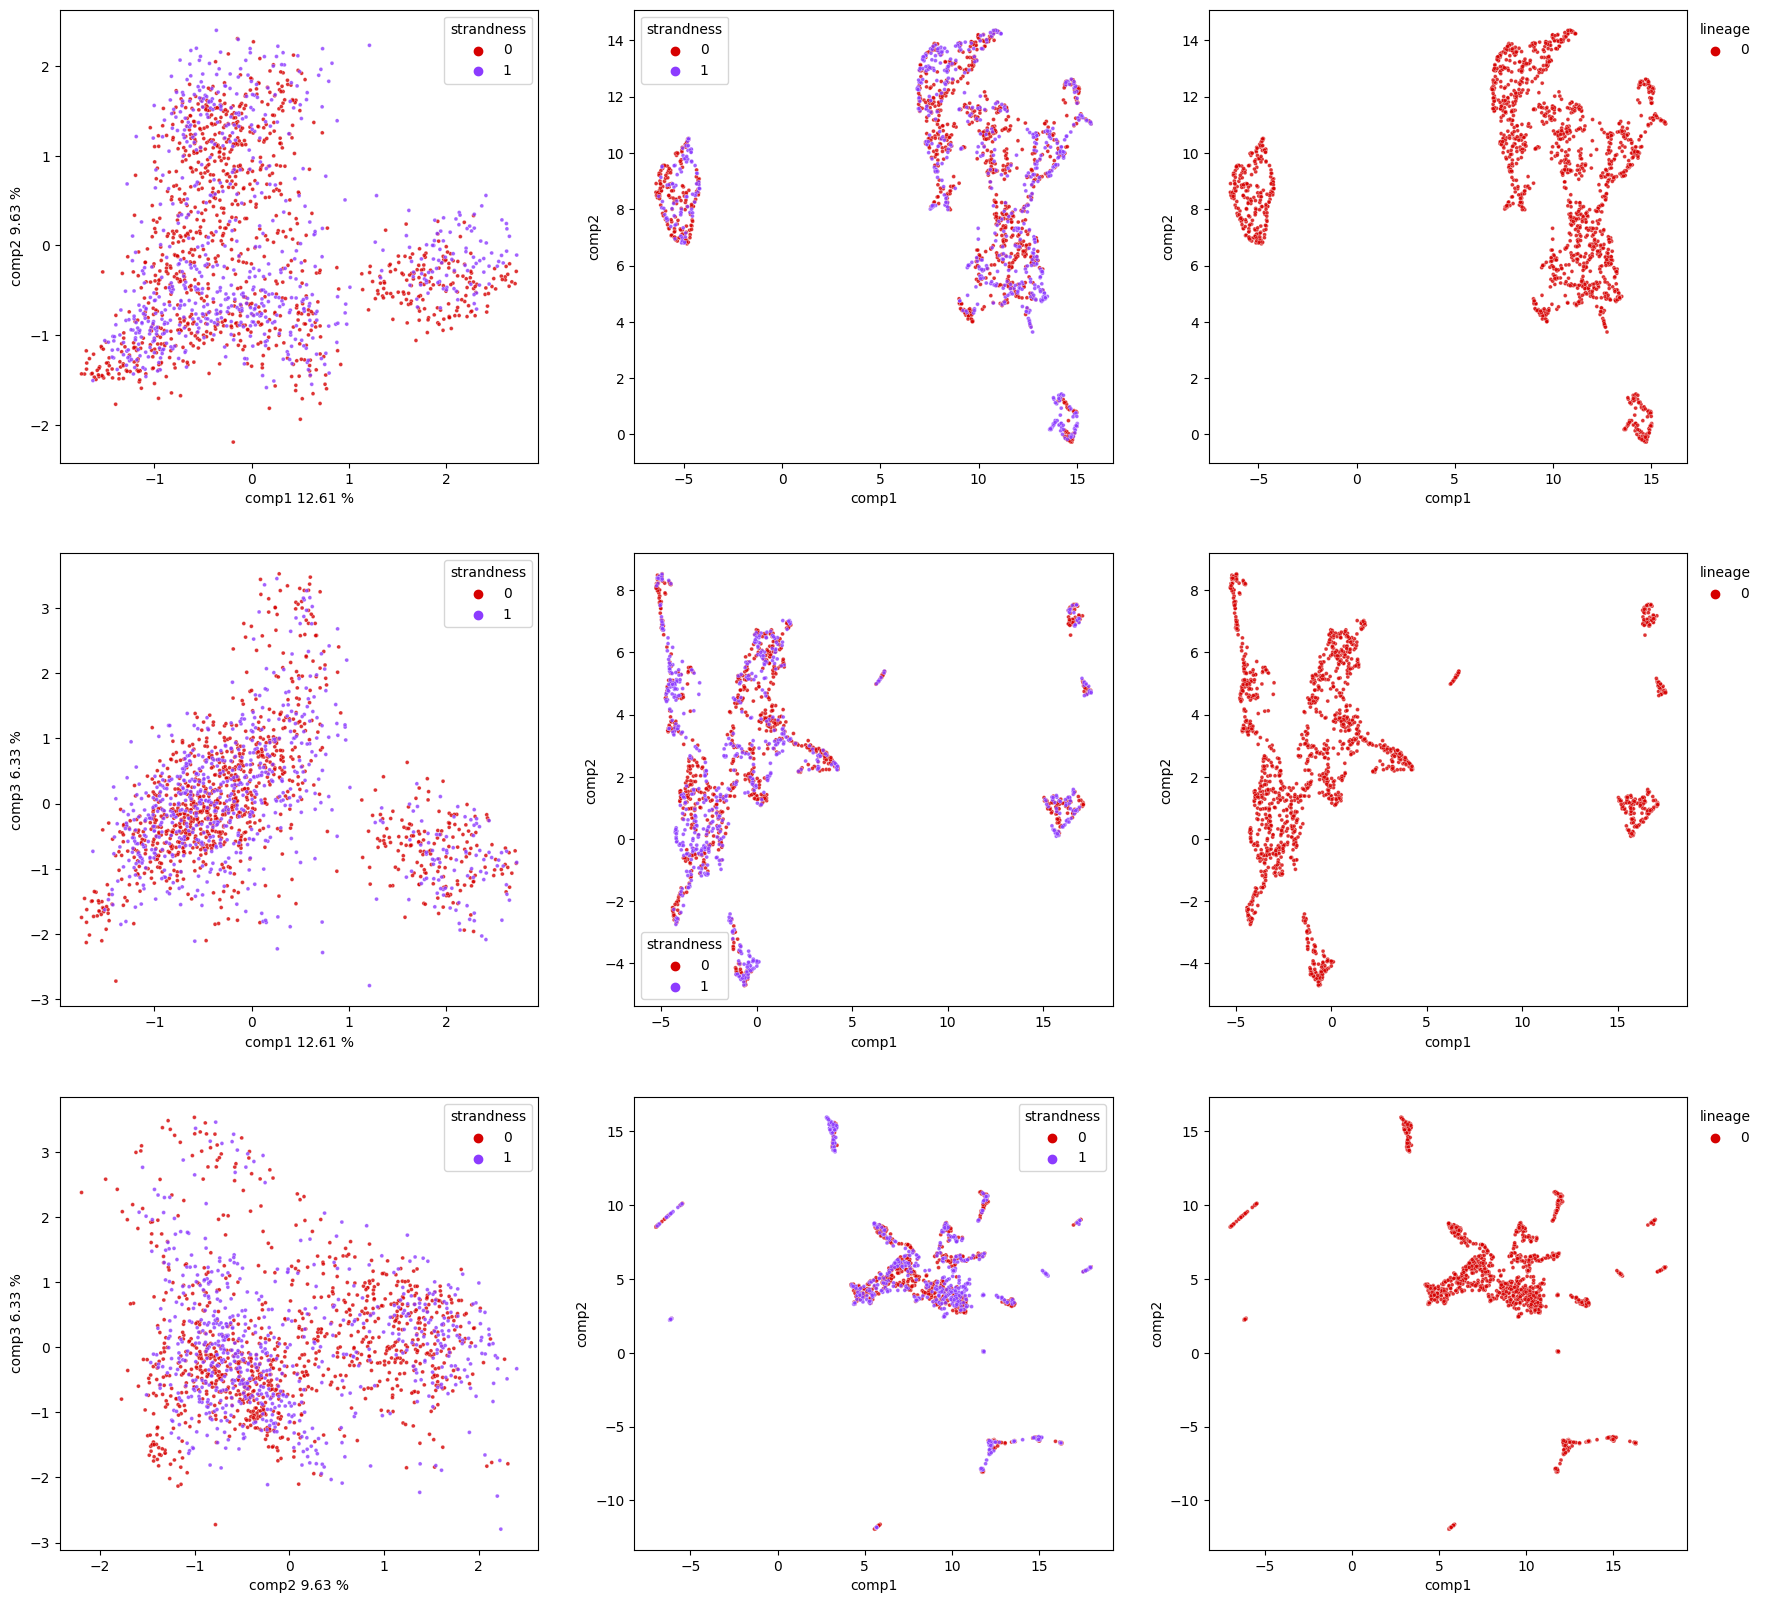

In [58]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
import seaborn as sns
import matplotlib.pyplot as plt
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(21, 20)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
#     strandness = np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*len(paired_data)])
    components = pca.fit_transform(tpm_corrected_24q4_public)
    print(components.shape, strandness_public.shape)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage_v2, "strandness": strandness_public})
        # pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*len(paired_data)])})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage_v2, "strandness": strandness_public})
        # pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage_v2, "strandness": strandness_public})
        # pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage_v2, "strandness": strandness_public})
    # pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage_v2, "strandness": strandness_public})
    # pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)
